# Análise de Dados SCADA de Turbina Eólica

This notebook will use machine learning and basic analysis on a SCADA data from a air turbine from the university of São Paulo to indentify period trends and different levels of productivity:

**Objective**: Temporal analysis and Identify diferent levels of productivity:
- **Variables**: Wind speed, power generated, RPM, tempeture, voltage in
- **Levels of productivity**: Really Good Performance, Good performance, Bad performance, Really Bad 

**Data**: CSV from 2022 from the SCADA system and the meaning of each column: https://zenodo.org/records/7348454

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Import CSV Files from Current Directory

In [2]:
df = pd.read_csv('data_swt_iee_usp_2022.csv',sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369731 entries, 0 to 369730
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Log Time            369731 non-null  object 
 1   SN#                 369731 non-null  int64  
 2   Software rev        369731 non-null  int64  
 3   opversion           369731 non-null  int64  
 4   Inv Time            369731 non-null  int64  
 5   watt-hours          369731 non-null  int64  
 6   Voltage In          369731 non-null  float64
 7   Voltage DC Bus      369731 non-null  float64
 8   Voltage L1          369731 non-null  float64
 9   Voltage L2          369731 non-null  float64
 10  voltage rise        369731 non-null  int64  
 11  min v from rpm      369731 non-null  int64  
 12  Current out         369731 non-null  float64
 13  Power out           369731 non-null  int64  
 14  Power reg           369731 non-null  int64  
 15  Power max           369731 non-nul

## Basic info

In [3]:
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (369731, 39)
Dataset columns: Index(['Log Time', 'SN#', 'Software rev', 'opversion', 'Inv Time',
       'watt-hours', 'Voltage In', 'Voltage DC Bus', 'Voltage L1',
       'Voltage L2', 'voltage rise', 'min v from rpm', 'Current out',
       'Power out', 'Power reg', 'Power max', 'Line Frequency',
       'Inverter Frequency', 'Line Resistance', 'RPM', 'Windspeed (ref)',
       'TargetTSR', 'Ramp RPM', 'Boost pulswidth', 'Max BPW',
       'current amplitude', ' T1', 'T2', 'T3', 'Event count',
       'Last event code', 'Event status', 'Event value', 'Turbine status',
       'Grid status', 'System status', 'Slave Status', 'Access Status',
       'Timer'],
      dtype='object')

First 5 rows:


,Log Time,SN#,Software rev,opversion,Inv Time,watt-hours,Voltage In,Voltage DC Bus,Voltage L1,Voltage L2,...,Event count,Last event code,Event status,Event value,Turbine status,Grid status,System status,Slave Status,Access Status,Timer
0,"2022:01:01:00:00:00,777",107605,202,300,1640979512,1303572,22.9,318.8,131.0,132.3,...,12501,111,0,0,1,0,0,0,2,0
1,"2022:01:01:00:01:00,766",107605,202,300,1640979572,1303572,22.8,319.0,131.0,132.3,...,12501,111,0,0,1,0,0,0,2,0
2,"2022:01:01:00:02:00,734",107605,202,300,1640979632,1303572,22.8,318.6,130.8,132.3,...,12501,111,0,0,1,0,0,0,2,0
3,"2022:01:01:00:03:00,743",107605,202,300,1640979692,1303572,22.8,317.8,130.6,132.3,...,12501,111,0,0,1,0,0,0,2,0
4,"2022:01:01:00:04:00,632",107605,202,300,1640979752,1303572,22.8,318.1,130.8,132.1,...,12501,111,0,0,1,0,0,0,2,0


In [4]:
print(df.isnull().sum() if df.isnull().sum().any() else "No null values")
print(df.duplicated().sum() if  df.duplicated().sum() > 0 else "No duplicate rows")

No null values
No duplicate rows
No duplicate rows


## Pre-process Data and more anlysis

In [5]:
df = df.rename(columns={' T1': 'T1'})  # rename T1 as it is wrong

df['Log Time'] = pd.to_datetime(df['Log Time'], format='%Y:%m:%d:%H:%M:%S,%f') # for the time analysis

df[['Windspeed (ref)', 'Power out', 'RPM', 'T1', 'T2', 'T3', 'Voltage In']].describe()

,Windspeed (ref),Power out,RPM,T1,T2,T3,Voltage In
count,369731.000000,369731.000000,369731.000000,369731.000000,369731.000000,369731.000000,369731.000000
mean,1.283963,42.485496,46.254555,23.399355,23.328488,20.871720,54.423698
std,1.857639,122.898077,67.058866,6.699796,6.787640,6.555141,47.200414
min,0.000000,0.000000,0.000000,6.600000,6.300000,4.500000,0.000000
25%,0.000000,0.000000,0.000000,18.500000,18.400000,16.100000,22.600000
50%,0.000000,0.000000,0.000000,21.800000,21.700000,19.500000,23.000000
75%,3.000000,14.000000,103.000000,27.500000,27.500000,24.800000,90.700000
max,18.000000,3713.000000,342.000000,45.100000,45.600000,42.100000,289.600000


## Feature Selection: Wind Speed, Generated Power, Rotation, Temperature and voltage in

In [6]:
selected_features = ['Windspeed (ref)', 'Power out', 'RPM', 'T1', 'T2', 'T3', 
                    'Voltage In']

df_features = df[selected_features + ['Log Time']]

df_features['month'] = df_features['Log Time'].dt.month # will use the log for date and time analysis

def get_season(month):
    if month in [12, 1, 2]: return 'Summer'    # Dezembro, Janeiro, Fevereiro
    elif month in [3, 4, 5]: return 'Autumn'   # Março, Abril, Maio
    elif month in [6, 7, 8]: return 'Winter'   # Jun, Jul, Agosto
    else: return 'Spring'                       # Setembro, Outubro, Novembro

df_features['season'] = df_features['month'].apply(get_season) # will apply the function to each row and return a column with the season
df_features['season_numeric'] = df_features['season'].map(
    {'Summer': 0, 'Autumn': 1, 'Winter': 2, 'Spring': 3})

# add them to list
selected_features.extend(['month', 'season_numeric'])

print(f"Dataset ready! Shape: {df_features.shape}")
print(f"Final features: {selected_features}")

df_features



Dataset ready! Shape: (369731, 11)
Final features: ['Windspeed (ref)', 'Power out', 'RPM', 'T1', 'T2', 'T3', 'Voltage In', 'month', 'season_numeric']


C:\Users\jomac\AppData\Local\Temp\ipykernel_10116\994910306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['month'] = df_features['Log Time'].dt.month # will use the log for date and time analysis
C:\Users\jomac\AppData\Local\Temp\ipykernel_10116\994910306.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['season'] = df_features['month'].apply(get_season) # will apply the function to each row and return a column with the season
C:\Users\jomac\AppData\Local\Temp\ipykernel_1011

,Windspeed (ref),Power out,RPM,T1,T2,T3,Voltage In,Log Time,month,season,season_numeric
0,0,0,0,19.4,19.3,17.7,22.9,2022-01-01 00:00:00.777,1,Summer,0
1,0,0,0,19.4,19.3,17.7,22.8,2022-01-01 00:01:00.766,1,Summer,0
2,0,0,0,19.4,19.3,17.7,22.8,2022-01-01 00:02:00.734,1,Summer,0
3,0,0,0,19.4,19.2,17.7,22.8,2022-01-01 00:03:00.743,1,Summer,0
4,0,0,0,19.4,19.2,17.6,22.8,2022-01-01 00:04:00.632,1,Summer,0
...,...,...,...,...,...,...,...,...,...,...,...
369726,0,0,0,36.5,36.3,32.7,23.0,2022-12-31 12:16:00.394,12,Summer,0
369727,0,0,0,36.5,36.4,32.7,23.0,2022-12-31 12:17:01.083,12,Summer,0
369728,0,0,5,36.5,36.4,32.6,25.7,2022-12-31 12:18:00.751,12,Summer,0
369729,0,0,0,36.4,36.3,32.6,25.0,2022-12-31 12:19:12.561,12,Summer,0


## Data Visualization


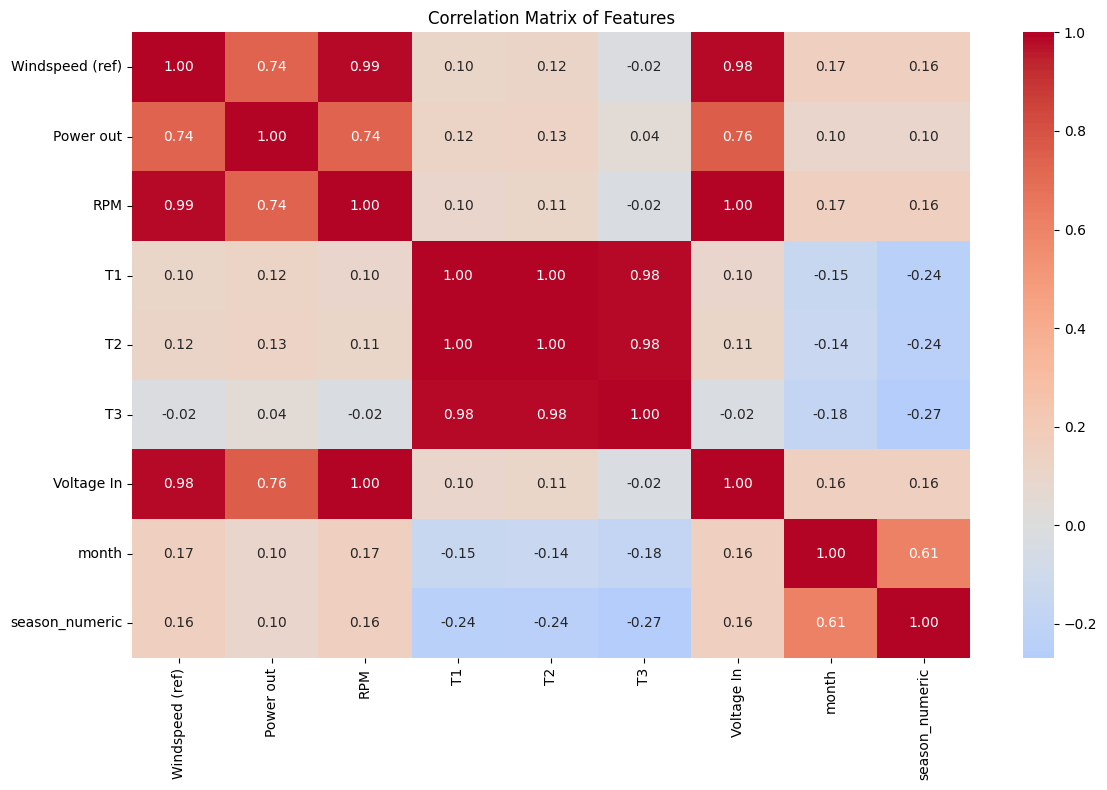

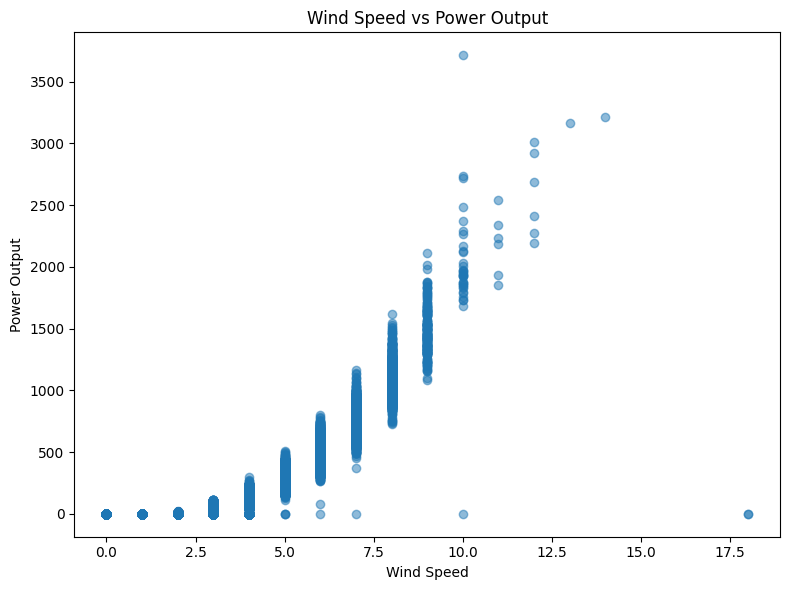

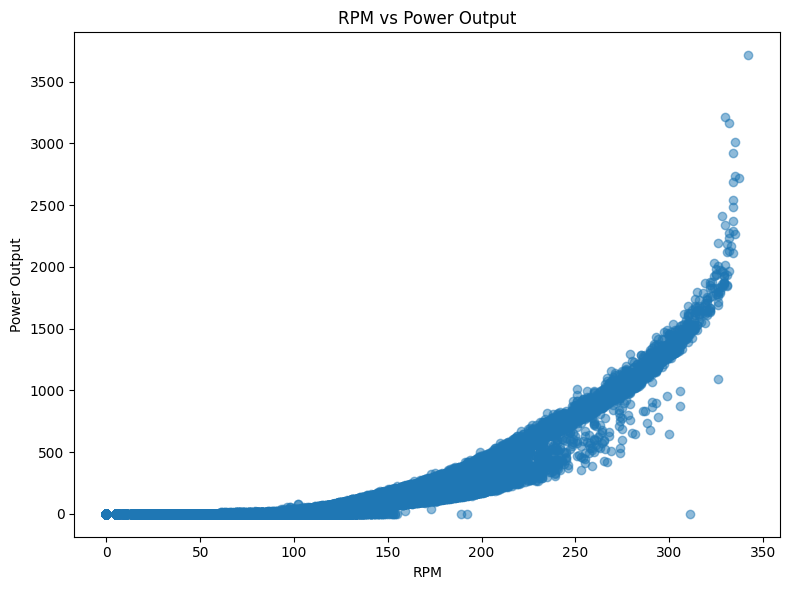

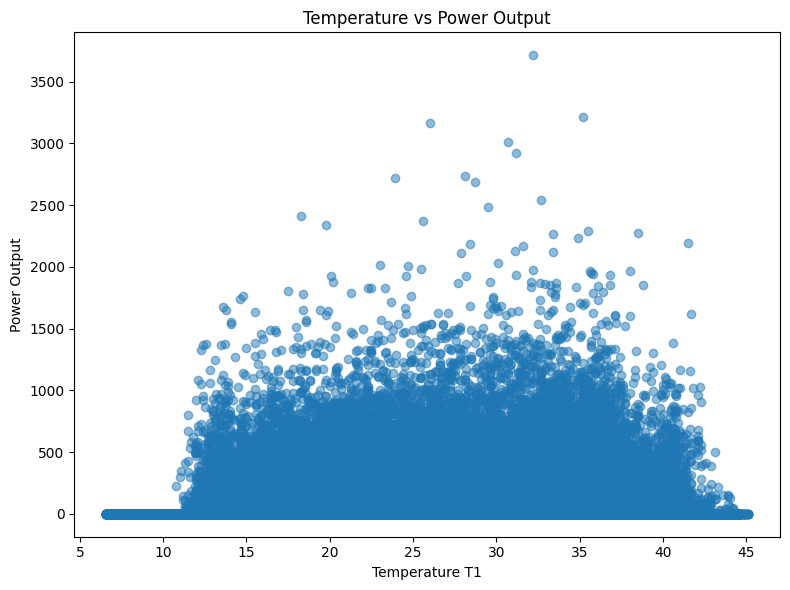

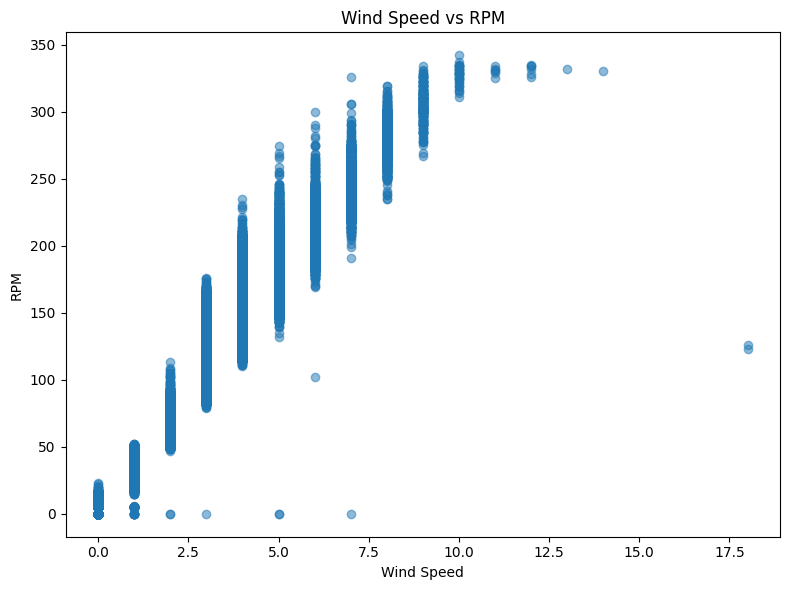

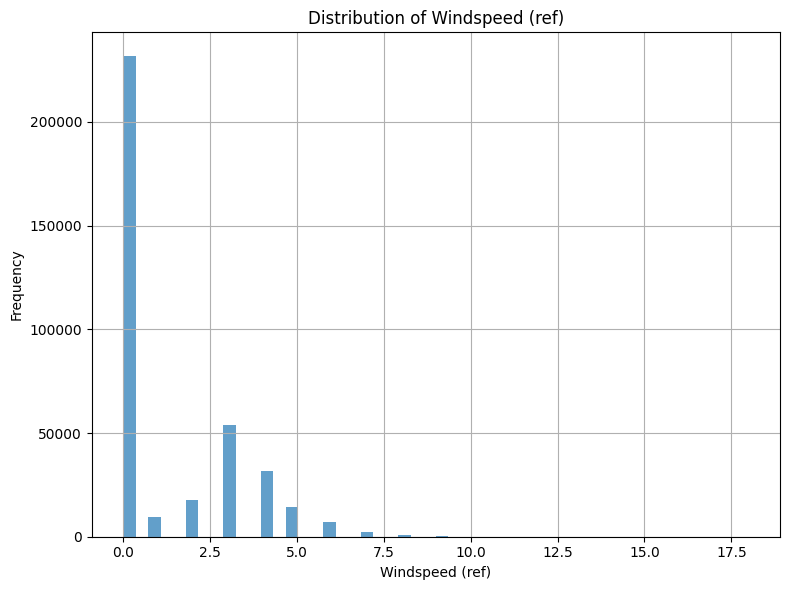

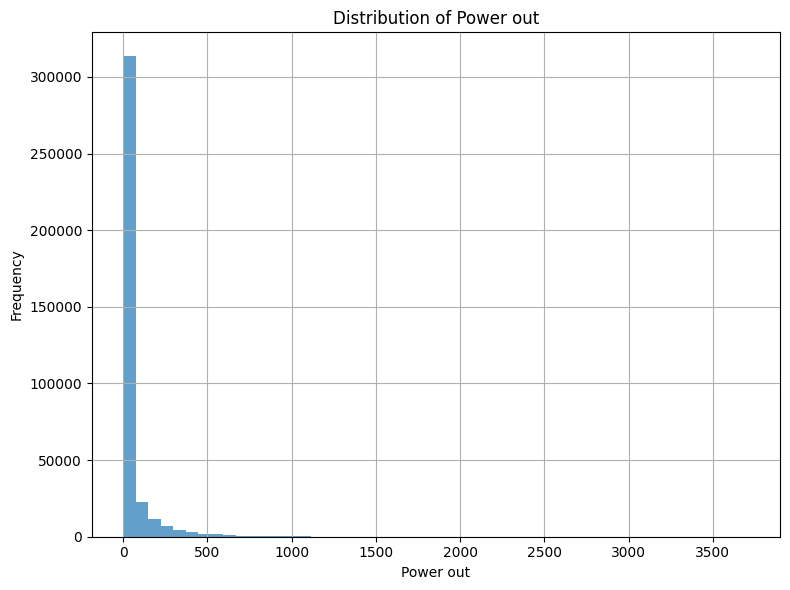

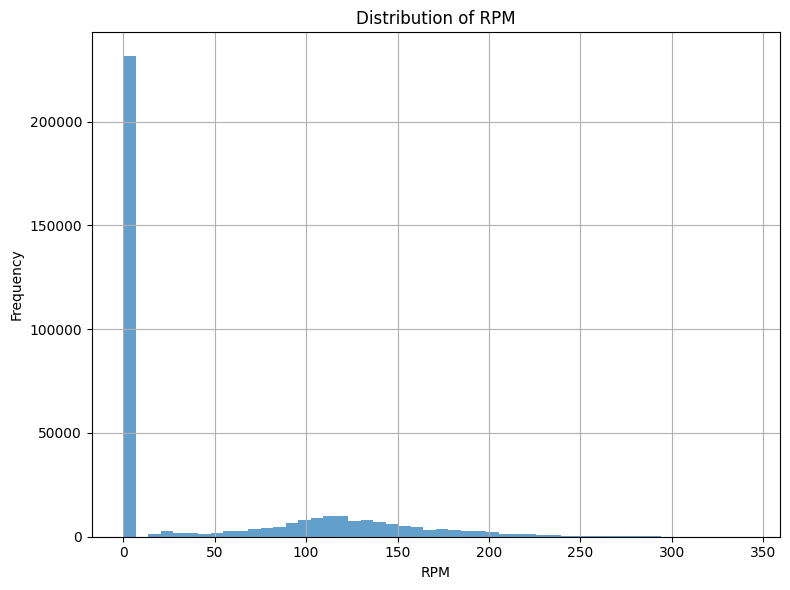

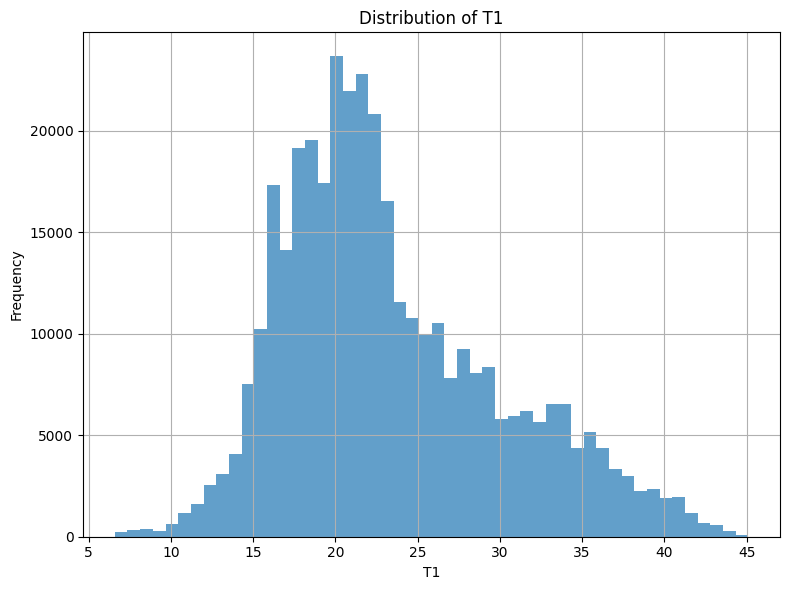

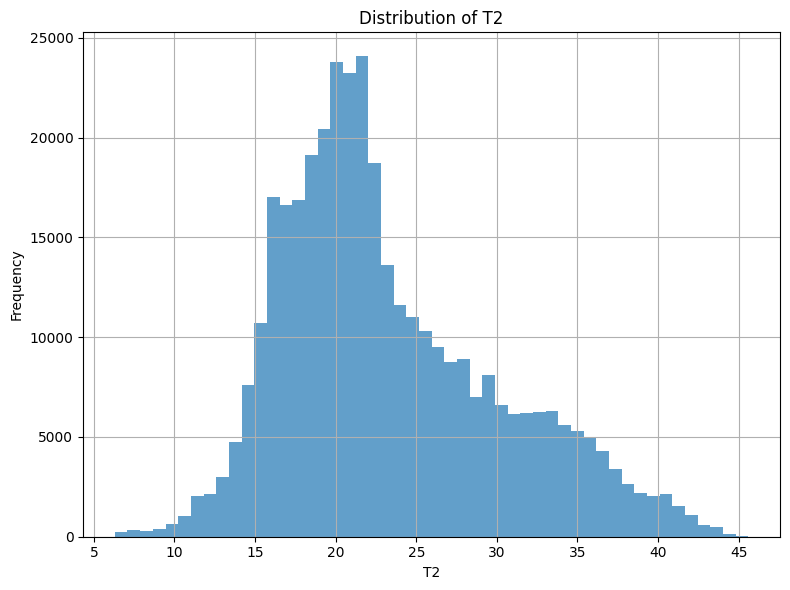

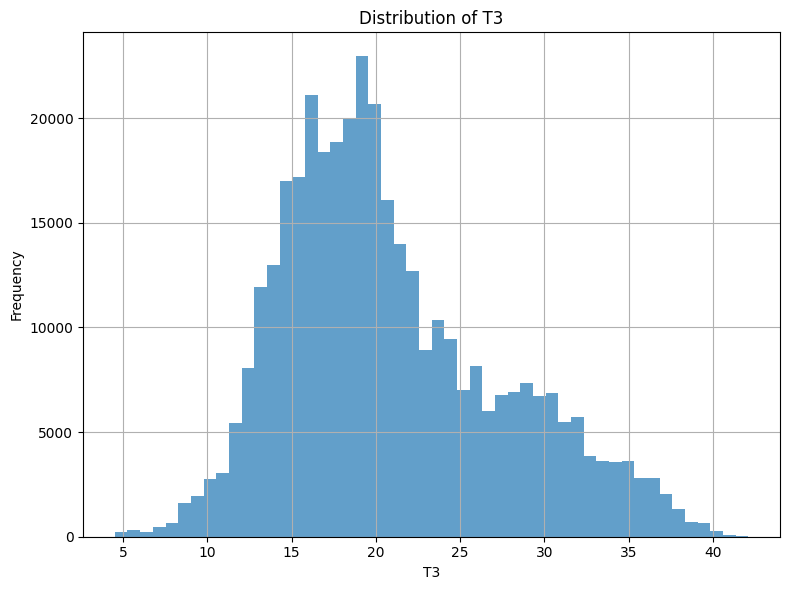

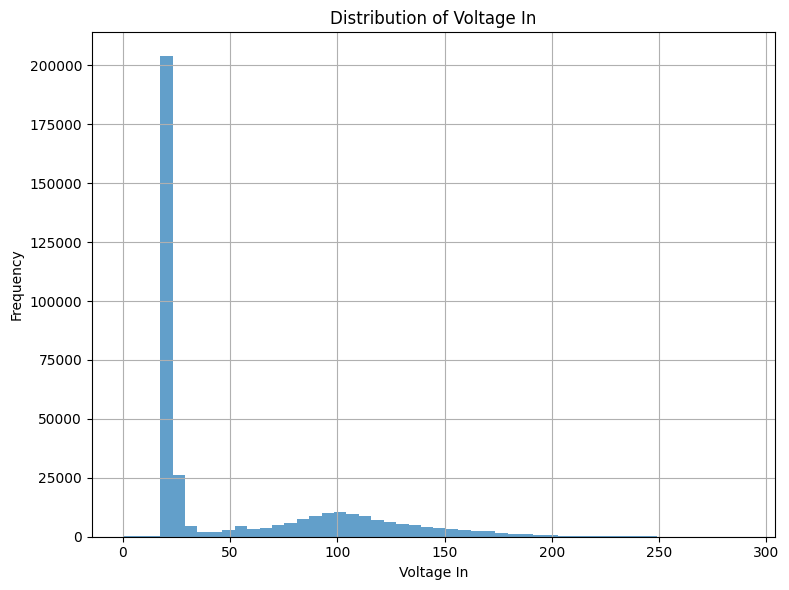

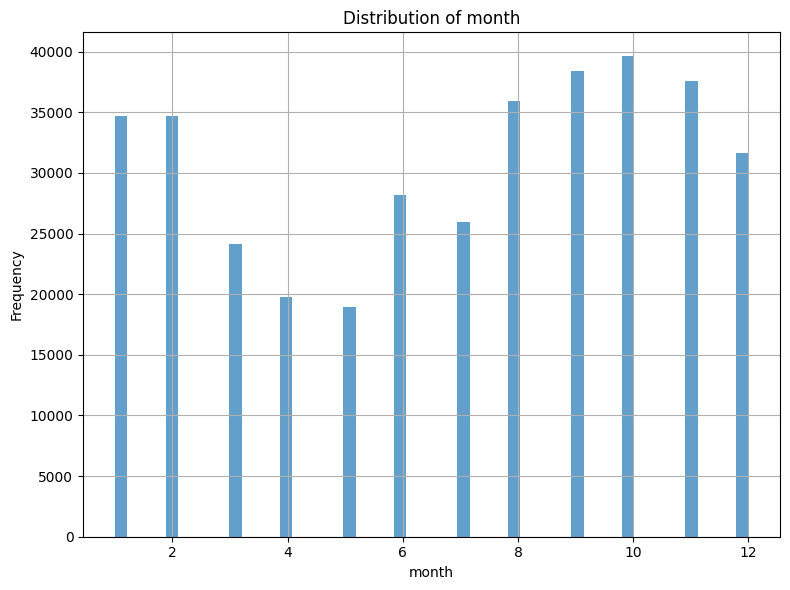

In [7]:
numerical_cols = df_features.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12, 8))
correlation_matrix = df_features[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_features['Windspeed (ref)'], df_features['Power out'], alpha=0.5)
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.title('Wind Speed vs Power Output')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_features['RPM'], df_features['Power out'], alpha=0.5)
plt.xlabel('RPM')
plt.ylabel('Power Output')
plt.title('RPM vs Power Output')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_features['T1'], df_features['Power out'], alpha=0.5)
plt.xlabel('Temperature T1')
plt.ylabel('Power Output')
plt.title('Temperature vs Power Output')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_features['Windspeed (ref)'], df_features['RPM'], alpha=0.5)
plt.xlabel('Wind Speed')
plt.ylabel('RPM')
plt.title('Wind Speed vs RPM')
plt.tight_layout()
plt.show()

for column in numerical_cols[:8]:
    plt.figure(figsize=(8, 6))
    df_features[column].hist(bins=50, alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

## Temporal Analysis

,Power out,Windspeed (ref),RPM
month,,,
1,32.03,0.98,35.47
2,30.20,1.01,36.52
3,32.48,0.83,29.67
4,23.46,0.96,34.79
5,17.39,0.47,16.84
6,17.05,0.70,25.64
7,36.35,1.20,43.75
8,60.10,1.74,62.77
9,61.90,1.82,65.60


,Power out,Windspeed (ref),RPM
season,,,
Autumn,25.09,0.76,27.41
Spring,61.87,1.77,63.75
Summer,33.55,1.07,38.50
Winter,39.78,1.26,45.66


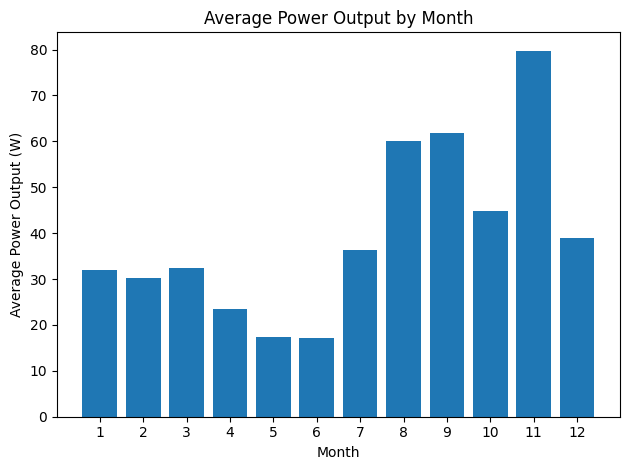

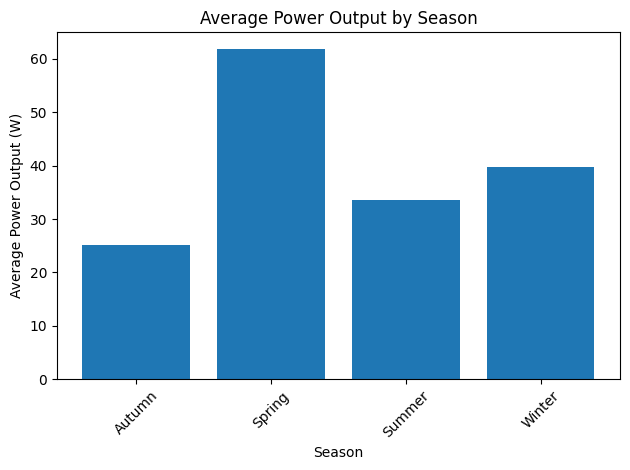

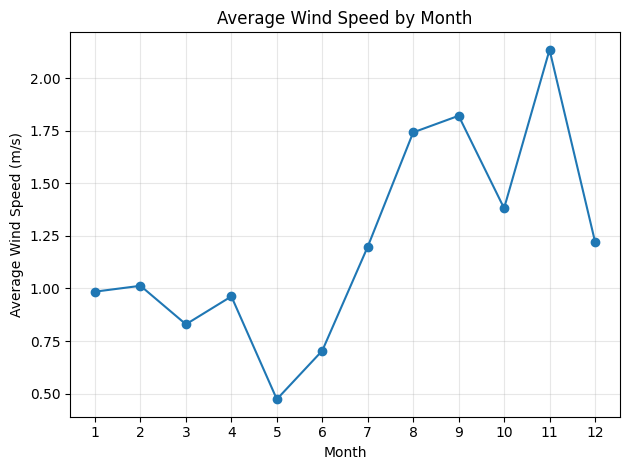

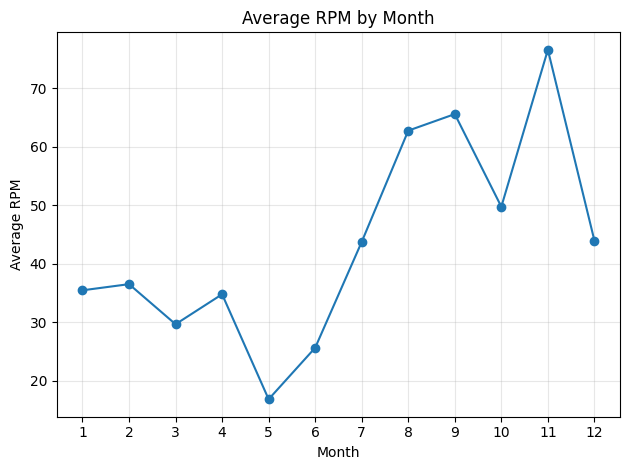

In [8]:
monthly_stats = df_features.groupby('month').agg({
    'Power out': 'mean',
    'Windspeed (ref)': 'mean',
    'RPM': 'mean'
}).round(2)

display(monthly_stats)

# Seasonal analysis
seasonal_stats = df_features.groupby('season').agg({
    'Power out': 'mean',
    'Windspeed (ref)': 'mean',
    'RPM': 'mean'
}).round(2)

display(seasonal_stats)

# Monthly power output
monthly_power = df_features.groupby('month')['Power out'].mean()
fig1, ax1 = plt.subplots()
ax1.bar(monthly_power.index, monthly_power.values)
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Power Output (W)')
ax1.set_title('Average Power Output by Month')
ax1.set_xticks(range(1, 13))
plt.tight_layout()
plt.show()

# Seasonal power output
seasonal_power = df_features.groupby('season')['Power out'].mean()
fig2, ax2 = plt.subplots()
ax2.bar(seasonal_power.index, seasonal_power.values)
ax2.set_xlabel('Season')
ax2.set_ylabel('Average Power Output (W)')
ax2.set_title('Average Power Output by Season')
ax2.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Monthly wind speed
monthly_wind = df_features.groupby('month')['Windspeed (ref)'].mean()
fig3, ax3 = plt.subplots()
ax3.plot(monthly_wind.index, monthly_wind.values, marker='o')
ax3.set_xlabel('Month')
ax3.set_ylabel('Average Wind Speed (m/s)')
ax3.set_title('Average Wind Speed by Month')
ax3.set_xticks(range(1, 13))
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Monthly RPM patterns
monthly_rpm = df_features.groupby('month')['RPM'].mean()
fig4, ax4 = plt.subplots()
ax4.plot(monthly_rpm.index, monthly_rpm.values, marker='o')
ax4.set_xlabel('Month')
ax4.set_ylabel('Average RPM')
ax4.set_title('Average RPM by Month')
ax4.set_xticks(range(1, 13))
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## K-Means Machine Learning


In [9]:
numerical_features = df_features.select_dtypes(include=[np.number]).columns

ml_features = numerical_features[:7]  # 'Windspeed (ref)', 'Power out', 'RPM', 'T1', 'T2', 'T3', 'Voltage In'
X = df_features[ml_features].copy()

#normalize the data
normalizer = StandardScaler()
X_normalized= normalizer.fit_transform(X)

k=2: Silhouette Score = 0.4685
k=3: Silhouette Score = 0.5001
k=3: Silhouette Score = 0.5001
k=4: Silhouette Score = 0.5167
k=4: Silhouette Score = 0.5167
k=5: Silhouette Score = 0.5160
k=5: Silhouette Score = 0.5160
k=6: Silhouette Score = 0.4542
k=6: Silhouette Score = 0.4542


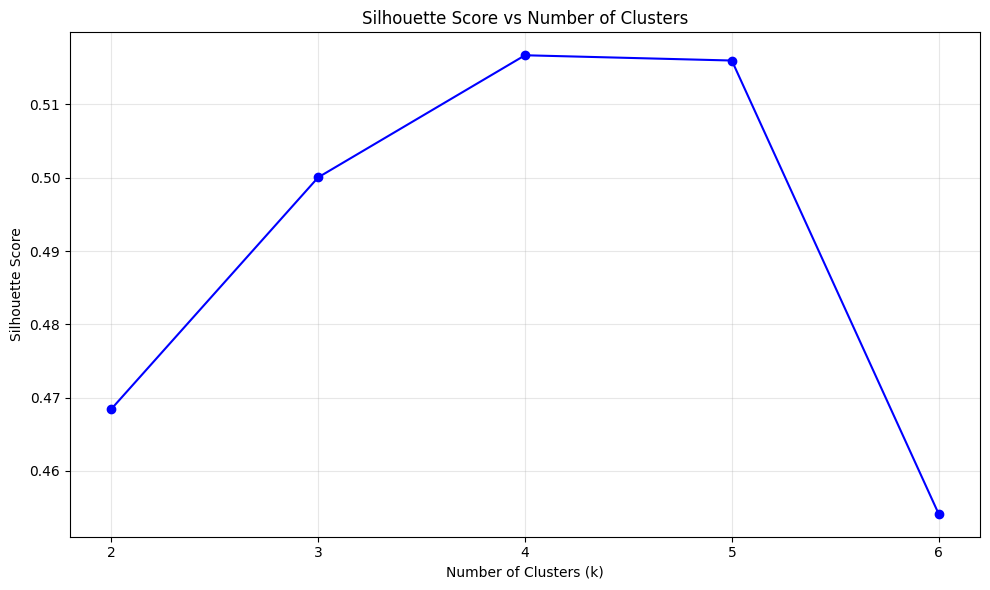

In [16]:
k_range = range(2, 7)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_normalized)
    silhouette_avg = silhouette_score(X_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Silhouette Score = {silhouette_avg:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

plt.tight_layout()
plt.show()

In [11]:
K = 5  # this  was the best value i found after trying a alot of different values
print(f"\nK-Means clustering with k={K}, Samples:")
kmeans_final = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_normalized)

df_clustered = df_features.copy()
df_clustered['cluster'] = cluster_labels
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"    Cluster {cluster}: {count:,} samples ({percentage:.1f}%)")
print(f"\nCluster Analysis:")
cluster_analysis = df_clustered.groupby('cluster')[ml_features].mean()
display(cluster_analysis)


K-Means clustering with k=5, Samples:
    Cluster 0: 177,055 samples (47.9%)
    Cluster 1: 37,074 samples (10.0%)
    Cluster 2: 70,577 samples (19.1%)
    Cluster 3: 71,479 samples (19.3%)
    Cluster 4: 13,546 samples (3.7%)

Cluster Analysis:
    Cluster 0: 177,055 samples (47.9%)
    Cluster 1: 37,074 samples (10.0%)
    Cluster 2: 70,577 samples (19.1%)
    Cluster 3: 71,479 samples (19.3%)
    Cluster 4: 13,546 samples (3.7%)

Cluster Analysis:


,Windspeed (ref),Power out,RPM,T1,T2,T3,Voltage In
cluster,,,,,,,
0,0.072175,0.000655,2.251701,19.478301,19.288971,17.544233,24.069511
1,3.684226,101.750688,133.150833,30.364970,30.480569,26.576496,113.549798
2,0.135313,0.003344,4.463182,32.470346,32.488224,30.334228,25.361985
3,3.255809,63.767120,118.823207,19.932631,19.916157,16.562624,103.601722
4,6.133250,544.628525,218.387125,26.617570,26.835346,22.187524,181.266462


,Cluster,perf,Avg Power (W),Avg Wind Speed (m/s),Avg RPM,Avg T1 (°C),Avg T2 (°C),Avg T3 (°C),Avg Voltage In,Main Month,Month %,Samples
0,0,Really Bad Performance,0.0,0.1,2.3,19.5,19.3,17.5,24.1,Jun,11.6%,"177,055"
1,1,Good performance,101.8,3.7,133.2,30.4,30.5,26.6,113.5,Nov,16.4%,"37,074"
2,2,Really Bad Performance,0.0,0.1,4.5,32.5,32.5,30.3,25.4,Feb,15.0%,"70,577"
3,3,Bad performance,63.8,3.3,118.8,19.9,19.9,16.6,103.6,Sep,19.8%,"71,479"
4,4,Really Good Performance,544.6,6.1,218.4,26.6,26.8,22.2,181.3,Nov,21.3%,"13,546"


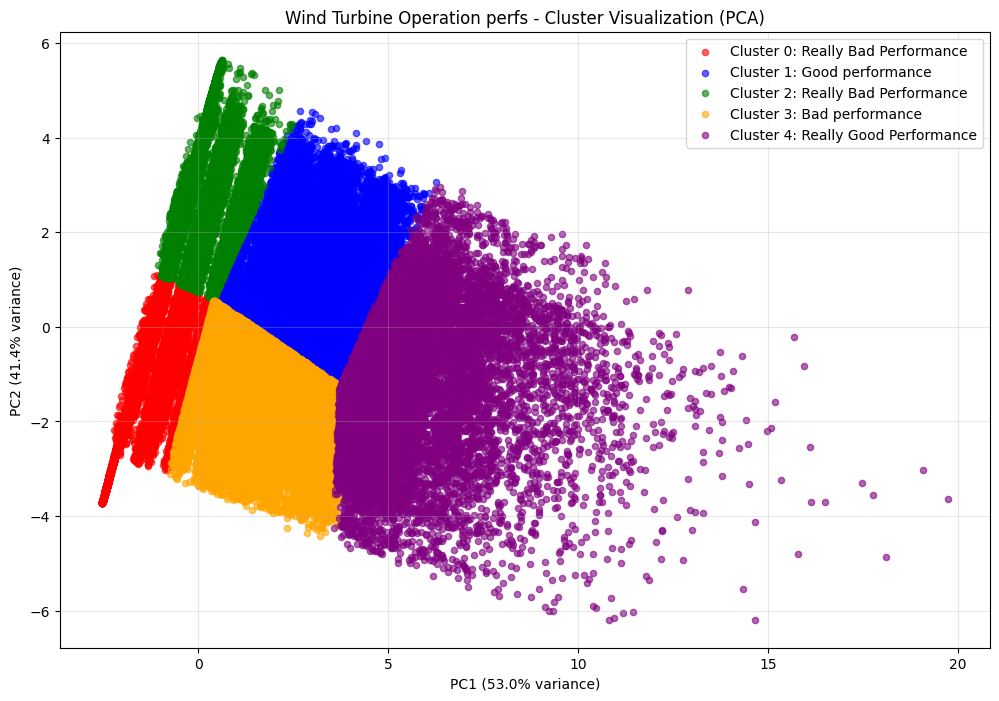

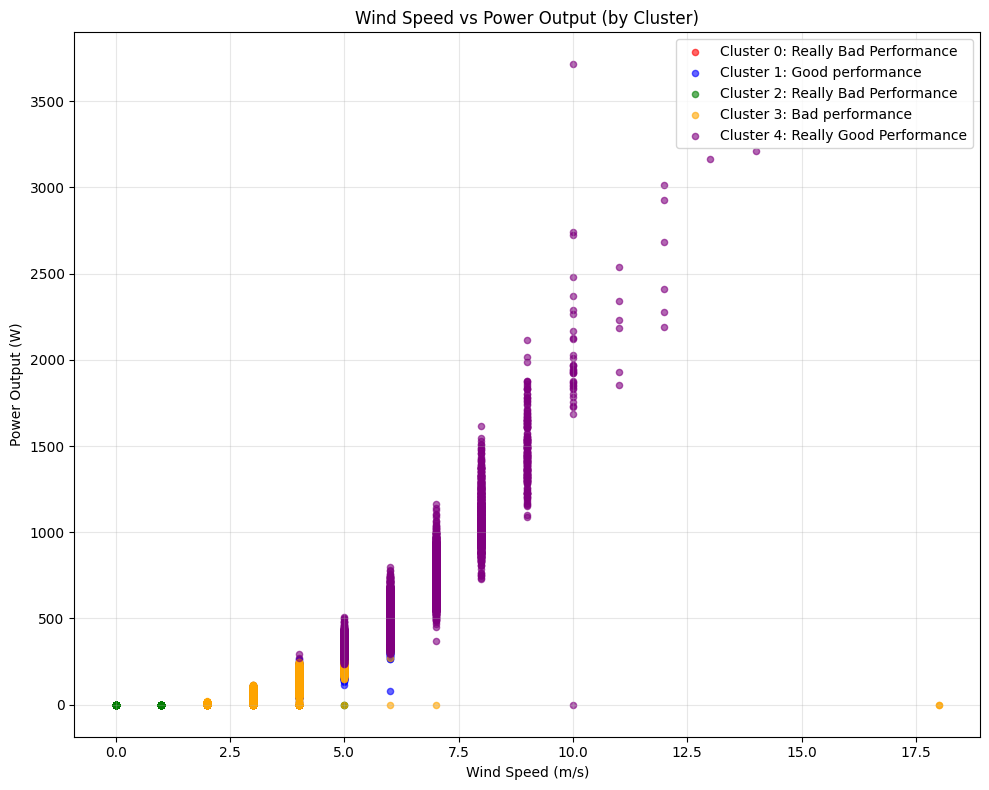

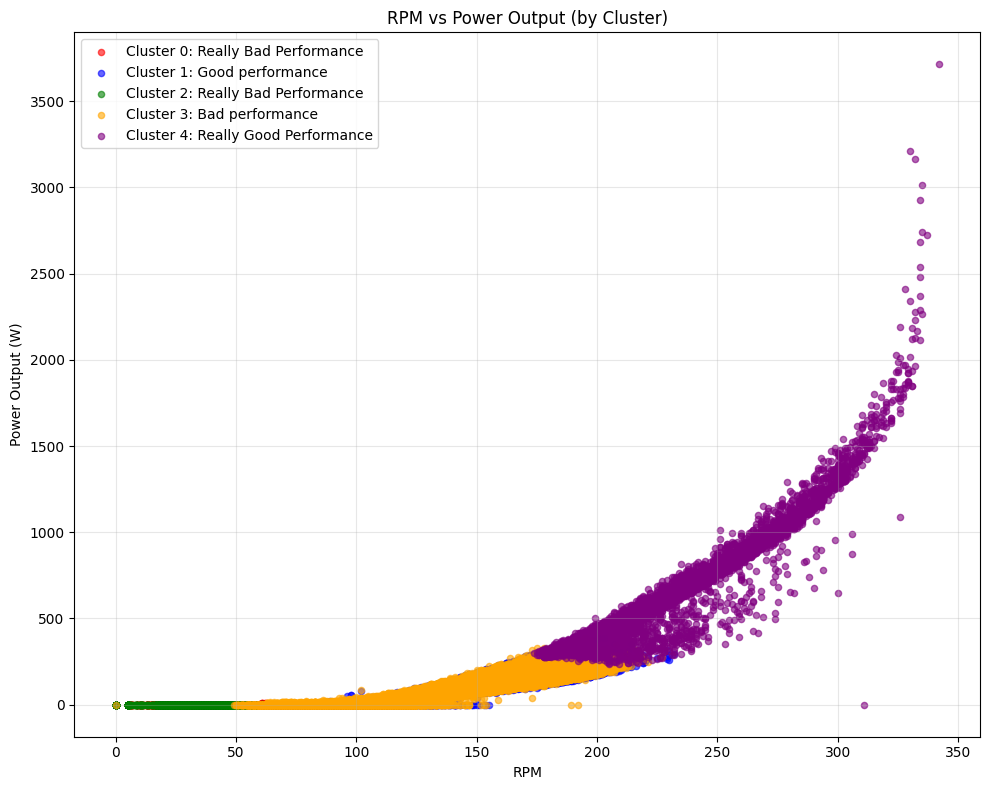

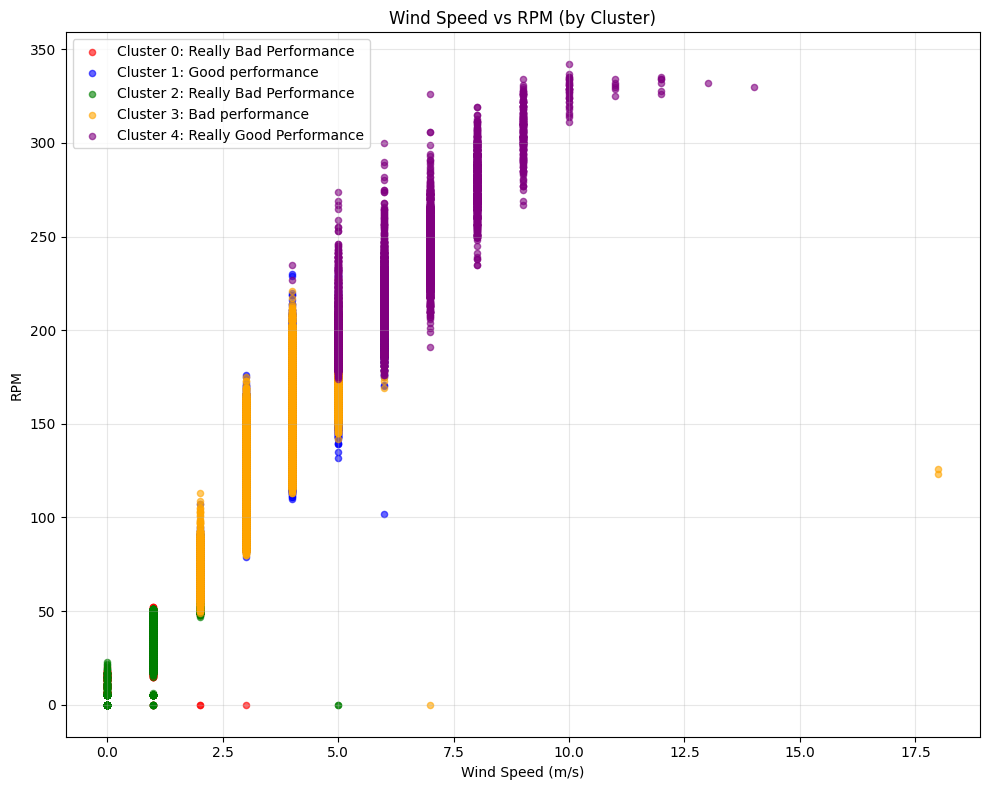

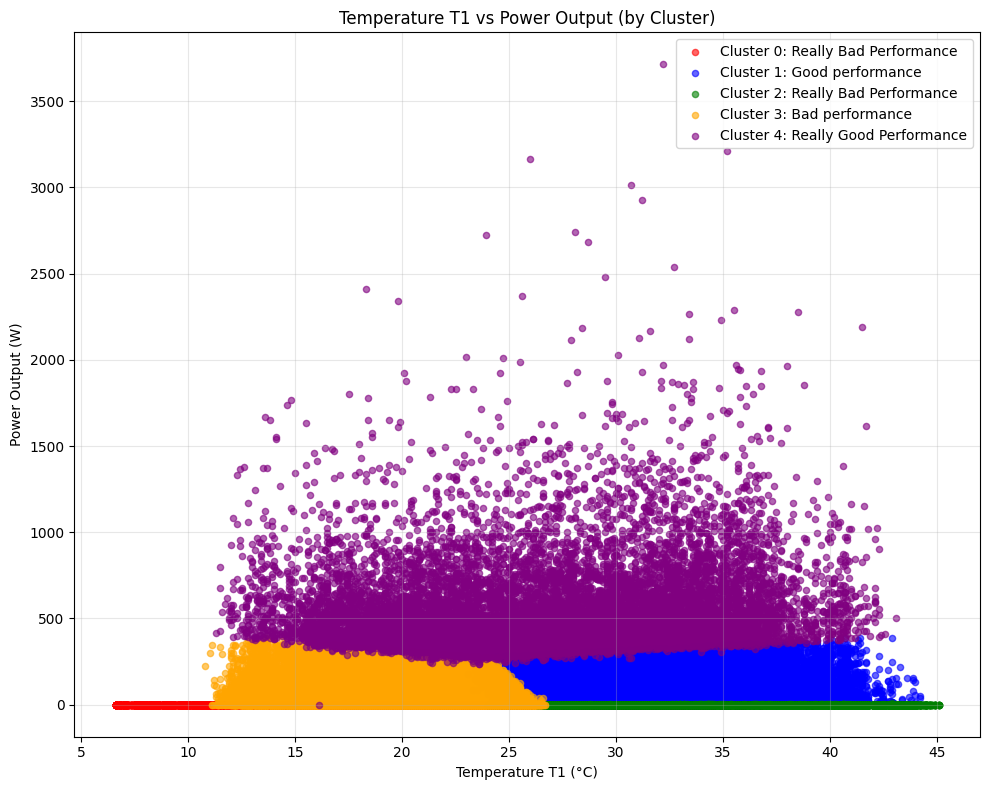

In [12]:
cluster_interpretation = {}

month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    
    avg_power = cluster_data['Power out'].mean()
    avg_wind_speed = cluster_data['Windspeed (ref)'].mean()
    avg_rpm = cluster_data['RPM'].mean()
    avg_t1 = cluster_data['T1'].mean()
    avg_t2 = cluster_data['T2'].mean()
    avg_t3 = cluster_data['T3'].mean()
    avg_voltageIn = cluster_data['Voltage In'].mean()
    
    # most representative month for this cluster
    month_counts = cluster_data['month'].value_counts()
    most_common_month = month_counts.index[0]
    month_percentage = (month_counts.iloc[0] / len(cluster_data)) * 100
    month_name = month_names.get(most_common_month, f"Month {most_common_month}")
    
    #Classify the cluster based on average power output and wind speed
    if avg_power >= 200 and avg_rpm >= 200:
        perf = 'Really Good Performance'
    elif (avg_power >= 100 and avg_power < 200) and (avg_rpm >= 100 and avg_rpm < 200):
        perf = 'Good performance'
    elif (avg_power >= 50 and avg_power < 100) and (avg_rpm >= 100 and avg_rpm < 200):
        perf = 'Bad performance'
    elif (avg_power < 100) and (avg_rpm < 100):
        perf = 'Really Bad Performance'
    
    cluster_interpretation[cluster_id] = {
        'perf': perf,
        'avg_power': avg_power,
        'avg_wind_speed': avg_wind_speed,
        'avg_rpm': avg_rpm,
        'avg_t1': avg_t1,
        'avg_t2': avg_t2,
        'avg_t3': avg_t3,
        'avg_voltageIn': avg_voltageIn,
        'most_common_month': most_common_month,
        'month_name': month_name,
        'month_percentage': month_percentage,
        'count': len(cluster_data)
    }
    
summary_data = []
for cluster_id in sorted(cluster_interpretation.keys()):
    info = cluster_interpretation[cluster_id]
    summary_data.append({
        'Cluster': cluster_id,
        'perf': info['perf'],
        'Avg Power (W)': f"{info['avg_power']:.1f}",
        'Avg Wind Speed (m/s)': f"{info['avg_wind_speed']:.1f}",
        'Avg RPM': f"{info['avg_rpm']:.1f}",
        'Avg T1 (°C)': f"{info['avg_t1']:.1f}",
        'Avg T2 (°C)': f"{info['avg_t2']:.1f}",
        'Avg T3 (°C)': f"{info['avg_t3']:.1f}",
        'Avg T3 (°C)': f"{info['avg_t3']:.1f}",
        'Avg Voltage In': f"{info['avg_voltageIn']:.1f}",
        'Main Month': info['month_name'],
        'Month %': f"{info['month_percentage']:.1f}%",
        'Samples': f"{info['count']:,}"
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_mask = df_clustered['cluster'] == cluster_id
    perf_name = cluster_interpretation[cluster_id]['perf']
    
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
                c=colors[cluster_id], label=f'Cluster {cluster_id}: {perf_name}', 
                alpha=0.6, s=20)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Wind Turbine Operation perfs - Cluster Visualization (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Wind Speed vs Power Output
if all(feat in df_clustered.columns for feat in ['Windspeed (ref)', 'Power out', 'RPM']):
    plt.figure(figsize=(10, 8))
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        perf_name = cluster_interpretation[cluster_id]['perf']
        
        plt.scatter(cluster_data['Windspeed (ref)'], 
                    cluster_data['Power out'], 
                    c=colors[cluster_id], 
                    label=f'Cluster {cluster_id}: {perf_name}',
                    alpha=0.6, s=20)
    
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Power Output (W)')
    plt.title('Wind Speed vs Power Output (by Cluster)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # RPM vs Power Output
    plt.figure(figsize=(10, 8))
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        perf_name = cluster_interpretation[cluster_id]['perf']
        
        plt.scatter(cluster_data['RPM'], 
                    cluster_data['Power out'], 
                    c=colors[cluster_id], 
                    label=f'Cluster {cluster_id}: {perf_name}',
                    alpha=0.6, s=20)
    
    plt.xlabel('RPM')
    plt.ylabel('Power Output (W)')
    plt.title('RPM vs Power Output (by Cluster)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Wind Speed vs RPM
    plt.figure(figsize=(10, 8))
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        perf_name = cluster_interpretation[cluster_id]['perf']
        
        plt.scatter(cluster_data['Windspeed (ref)'], 
                    cluster_data['RPM'], 
                    c=colors[cluster_id], 
                    label=f'Cluster {cluster_id}: {perf_name}',
                    alpha=0.6, s=20)
    
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('RPM')
    plt.title('Wind Speed vs RPM (by Cluster)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Temperature T1 vs Power Output
    plt.figure(figsize=(10, 8))
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        perf_name = cluster_interpretation[cluster_id]['perf']
        
        plt.scatter(cluster_data['T1'], 
                    cluster_data['Power out'], 
                    c=colors[cluster_id], 
                    label=f'Cluster {cluster_id}: {perf_name}',
                    alpha=0.6, s=20)
    
    plt.xlabel('Temperature T1 (°C)')
    plt.ylabel('Power Output (W)')
    plt.title('Temperature T1 vs Power Output (by Cluster)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7.1 DBSCAN Analysis attempt

In [13]:
from sklearn.cluster import DBSCAN

print(f"Using features: {ml_features}")

# params
eps = 0.5
min_samples = 3 

max_size = 100000  # Maximum dataset size for DBSCAN, workaround as i run out of memory kk

np.random.seed(42)
sample_indices = np.random.choice(len(X_normalized), max_size, replace=False)
X_sample = X_normalized[sample_indices]

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
sample_labels = dbscan.fit_predict(X_sample)

dbscan_labels = np.full(len(X_normalized), -2)  # -2 = unprocessed, -1 = noise, >=0 = cluster
dbscan_labels[sample_indices] = sample_labels

df_dbscan = df_features.copy()
df_dbscan['dbscan_cluster'] = dbscan_labels
df_dbscan

Using features: Index(['Windspeed (ref)', 'Power out', 'RPM', 'T1', 'T2', 'T3', 'Voltage In'], dtype='object')


,Windspeed (ref),Power out,RPM,T1,T2,T3,Voltage In,Log Time,month,season,season_numeric,dbscan_cluster
0,0,0,0,19.4,19.3,17.7,22.9,2022-01-01 00:00:00.777,1,Summer,0,0
1,0,0,0,19.4,19.3,17.7,22.8,2022-01-01 00:01:00.766,1,Summer,0,-2
2,0,0,0,19.4,19.3,17.7,22.8,2022-01-01 00:02:00.734,1,Summer,0,0
3,0,0,0,19.4,19.2,17.7,22.8,2022-01-01 00:03:00.743,1,Summer,0,-2
4,0,0,0,19.4,19.2,17.6,22.8,2022-01-01 00:04:00.632,1,Summer,0,-2
...,...,...,...,...,...,...,...,...,...,...,...,...
369726,0,0,0,36.5,36.3,32.7,23.0,2022-12-31 12:16:00.394,12,Summer,0,-2
369727,0,0,0,36.5,36.4,32.7,23.0,2022-12-31 12:17:01.083,12,Summer,0,-2
369728,0,0,5,36.5,36.4,32.6,25.7,2022-12-31 12:18:00.751,12,Summer,0,0
369729,0,0,0,36.4,36.3,32.6,25.0,2022-12-31 12:19:12.561,12,Summer,0,-2


In [14]:
# DBSCAN cluster distribution

dbscan_counts = pd.Series(dbscan_labels).value_counts().sort_index()
for cluster_id, count in dbscan_counts.items():
    percentage = (count / len(dbscan_labels)) * 100
    if cluster_id == -2:
        cluster_name = "Unprocessed"
    elif cluster_id == -1:
        cluster_name = "Noise"
    else:
        cluster_name = f"Cluster {cluster_id}"
    print(f"  {cluster_name}: {count:,} samples ({percentage:.1f}%)")

  Unprocessed: 269,731 samples (73.0%)
  Noise: 117 samples (0.0%)
  Cluster 0: 62,819 samples (17.0%)
  Cluster 1: 635 samples (0.2%)
  Cluster 2: 14,511 samples (3.9%)
  Cluster 3: 4,684 samples (1.3%)
  Cluster 4: 8,494 samples (2.3%)
  Cluster 5: 3,956 samples (1.1%)
  Cluster 6: 1,871 samples (0.5%)
  Cluster 7: 2,684 samples (0.7%)
  Cluster 8: 4 samples (0.0%)
  Cluster 9: 4 samples (0.0%)
  Cluster 10: 7 samples (0.0%)
  Cluster 11: 166 samples (0.0%)
  Cluster 12: 5 samples (0.0%)
  Cluster 13: 4 samples (0.0%)
  Cluster 14: 3 samples (0.0%)
  Cluster 15: 3 samples (0.0%)
  Cluster 16: 3 samples (0.0%)
  Cluster 17: 3 samples (0.0%)
  Cluster 18: 4 samples (0.0%)
  Cluster 19: 6 samples (0.0%)
  Cluster 20: 4 samples (0.0%)
  Cluster 21: 4 samples (0.0%)
  Cluster 22: 3 samples (0.0%)
  Cluster 23: 3 samples (0.0%)
  Cluster 24: 3 samples (0.0%)


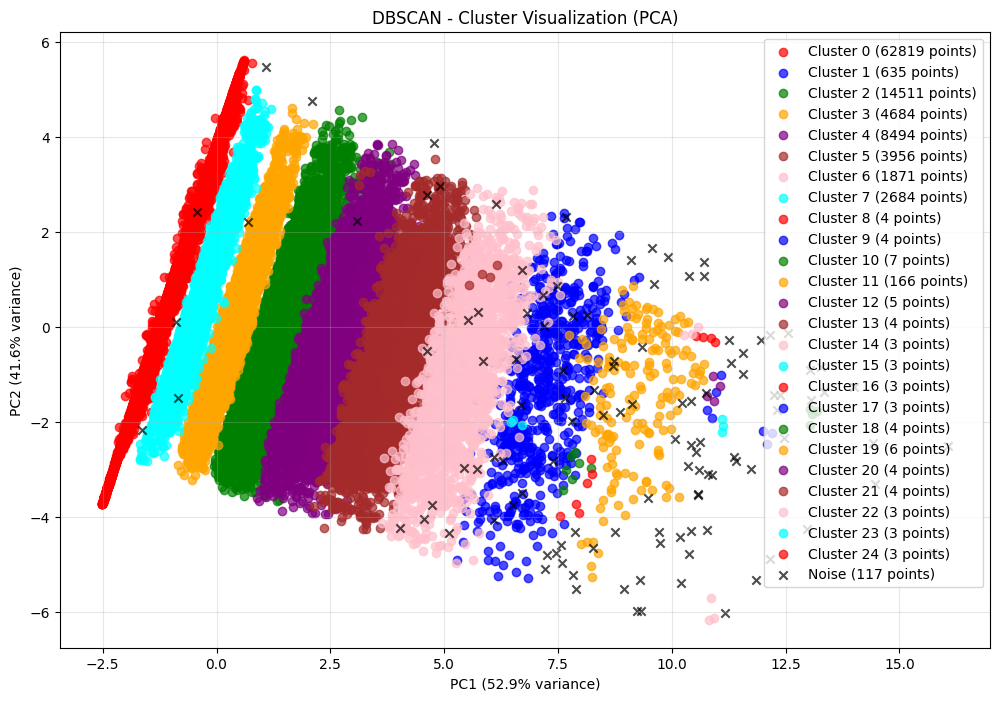

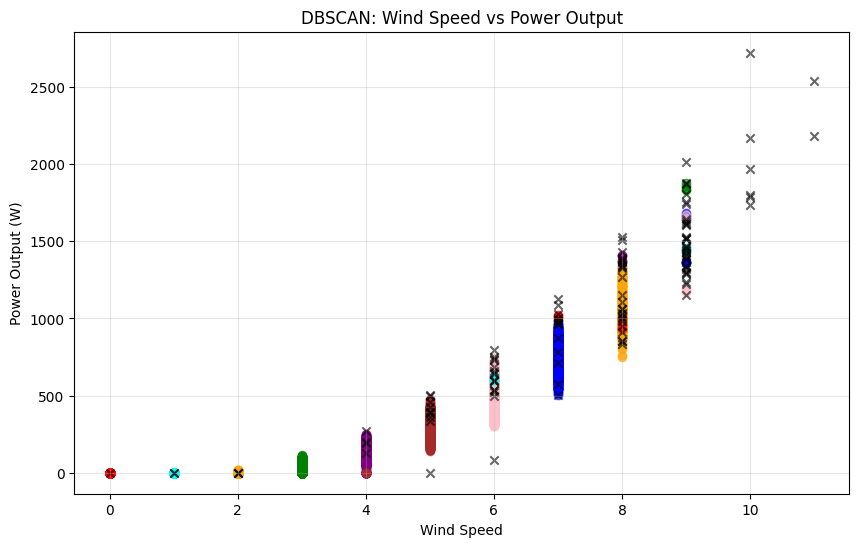

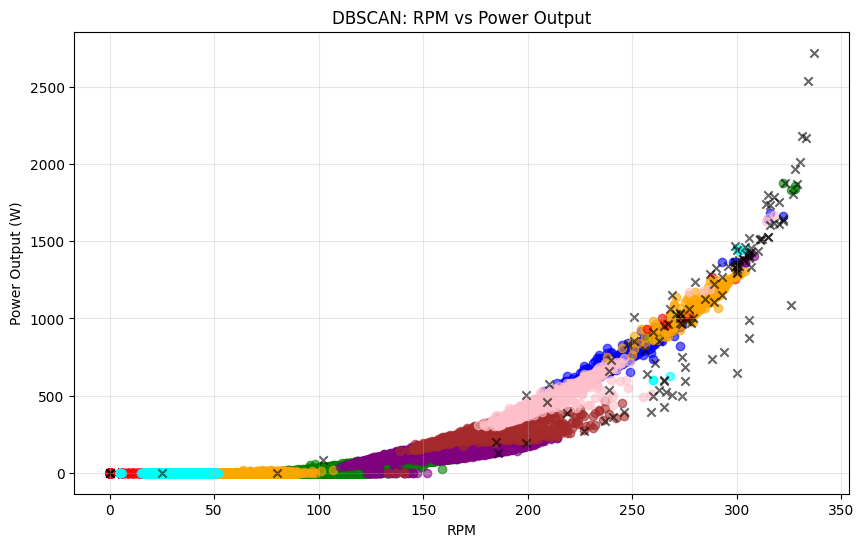

In [15]:
processed_mask = (dbscan_labels != -2)  # no unprocessed points
processed_labels = dbscan_labels[processed_mask]
X_processed = X_normalized[processed_mask]

unique_labels = set(processed_labels)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan']

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_processed)

plt.figure(figsize=(12, 8))

for i, k in enumerate(unique_labels):
    if k == -1:
        color = 'black'
        label = f'Noise ({list(processed_labels).count(-1)} points)'
        marker = 'x'
    else:
        color = colors[i % len(colors)]
        label = f'Cluster {k} ({list(processed_labels).count(k)} points)'
        marker = 'o'
    
    class_member_mask = (processed_labels == k)
    xy = X_pca_2d[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=color, marker=marker, alpha=0.7, label=label)

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
plt.title('DBSCAN - Cluster Visualization (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

df_processed = df_dbscan[processed_mask]

# Wind Speed vs Power Output
plt.figure(figsize=(10, 6))
for i, k in enumerate(unique_labels):
    if k == -1:
        color = 'black'
        marker = 'x'
    else:
        color = colors[i % len(colors)]
        marker = 'o'
    
    class_member_mask = (df_processed['dbscan_cluster'] == k)
    cluster_data = df_processed[class_member_mask]
    
    plt.scatter(cluster_data['Windspeed (ref)'], cluster_data['Power out'], 
                c=color, marker=marker, alpha=0.6)

plt.xlabel('Wind Speed')
plt.ylabel('Power Output (W)')
plt.title('DBSCAN: Wind Speed vs Power Output')
plt.grid(True, alpha=0.3)
plt.show()

# RPM vs Power Output
plt.figure(figsize=(10, 6))
for i, k in enumerate(unique_labels):
    if k == -1:
        color = 'black'
        marker = 'x'
    else:
        color = colors[i % len(colors)]
        marker = 'o'
    
    class_member_mask = (df_processed['dbscan_cluster'] == k)
    cluster_data = df_processed[class_member_mask]
    
    plt.scatter(cluster_data['RPM'], cluster_data['Power out'], 
                c=color, marker=marker,alpha=0.6)

plt.xlabel('RPM')
plt.ylabel('Power Output (W)')
plt.title('DBSCAN: RPM vs Power Output')
plt.grid(True, alpha=0.3)
plt.show()